## Credit Card Customer Clustering

### Import Libraries

In [36]:
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical computing
import matplotlib.pyplot as plt     # for data visualization
import matplotlib.dates as mdates   
import seaborn as sns    # for advanced data visualization
import sklearn           # for machine learning algorithms
from sklearn.feature_selection import mutual_info_classif
import statsmodels.api as sm        # for statistical models and tests
import scipy.stats as stats         # for scientific computing and statistics
import random
from sklearn.metrics import make_scorer
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from datetime import datetime

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from yellowbrick.cluster import KElbowVisualizer
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

#from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error

# Models
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
#from sklearn.linear_model import LogisticRegression
#import xgboost as xgb

### Data information

This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the 6 months. The file is at a customer level with 18 behavioral variables.

Following is the Data Dictionary for Credit Card dataset :-

- **CUST_ID** : Identification of Credit Card holder (Categorical)
- **BALANCE** : Balance amount left in their account to make purchases (
- **BALANCE_FREQUENCY** : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- **PURCHASES** : Amount of purchases made from account
- **ONEOFF_PURCHASES** : Maximum purchase amount done in one-go
- **INSTALLMENTS_PURCHASES** : Amount of purchase done in installment
- **CASH_ADVANCE** : Cash in advance given by the user
- **PURCHASES_FREQUENCY** : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- **ONEOFFPURCHASESFREQUENCY** : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- **PURCHASESINSTALLMENTSFREQUENCY** : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- **CASHADVANCEFREQUENCY** : How frequently the cash in advance being paid
- **CASHADVANCETRX** : Number of Transactions made with "Cash in Advanced"
- **PURCHASES_TRX** : Numbe of purchase transactions made
- **CREDIT_LIMIT** : Limit of Credit Card for user
- **PAYMENTS** : Amount of Payment done by user
- **MINIMUM_PAYMENTS** : Minimum amount of payments made by user
- **PRCFULLPAYMENT** : Percent of full payment paid by user
- **TENURE** : Tenure of credit card service for user

### Import data

In [4]:
# Set the file path and name
path = './data/CC_GENERAL.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(path)

# Copy of dataset
df_original = df

### Auxiliar Functions

In [5]:
# Function to print main info about the dataset

def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
#    print(df.isnull().sum())
    print(df.isna().mean()*100)
#    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
#    print(df.head())
#    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
#    print(df.tail())
#    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
#    print(df.describe())
#    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
#    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))


### Data overview

In [6]:
ds_info(df)

SIZE
161100

SHAPE
(8950, 18)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                 

In [7]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [8]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Analysis**:
- The dataset consists of 18 columns, including 1 object column (CUST_ID) and 3 integer columns, while the remaining columns are of float type.

- Among the variables, there are two columns with null values. The "MINIMUM_PAYMENTS" column has null values in approximately 3.5% of the data, while the "CREDIT_LIMIT" column has null values in only 0.01% of the data.

- There are several variables in the dataset where the mean is significantly higher than the median. This suggests the presence of skewness in these variables, indicating a potential imbalance or non-normal distribution. Further investigation is necessary to understand the nature and implications of this skewness in the dataset.

### Exploratory Data Analysis

#### Null values

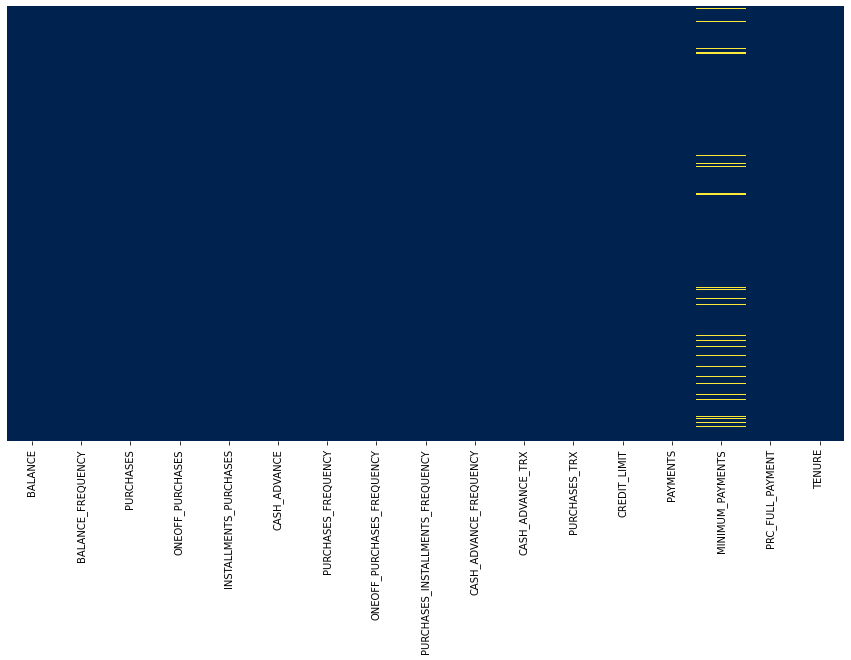

In [9]:
# Select all columns
columns_to_visualize = df.columns[1:20]

# Create a subset DataFrame with selected columns
subset = df[columns_to_visualize]
# Increase the size of the plot
plt.figure(figsize=(15, 8))
# Generate the heatmap
sns.heatmap(subset.isnull(),yticklabels=False,cbar=False,cmap='cividis')
# Display
plt.show()

#### Skewness analysis

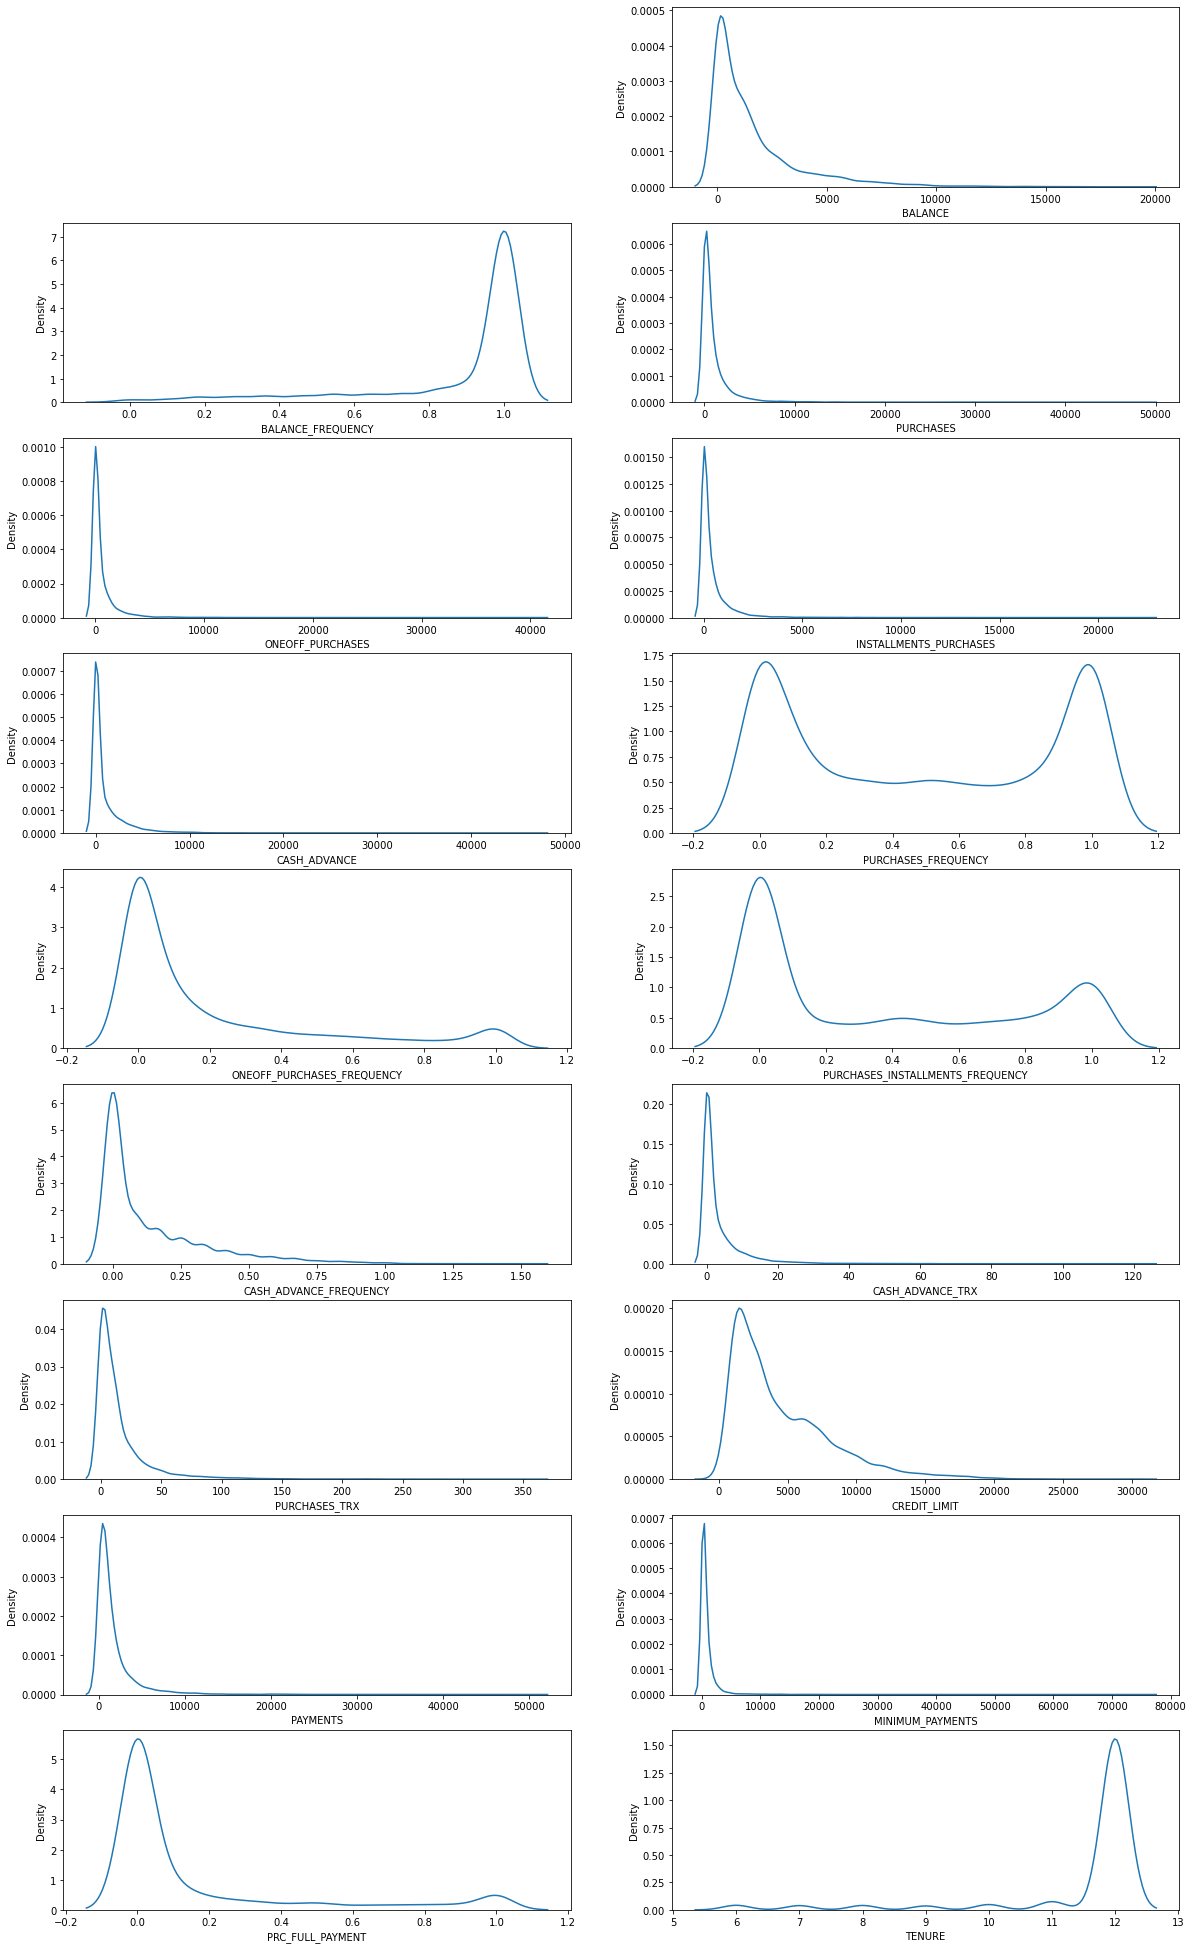

In [10]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

- As mentioned earlier based on comparison with median and average values, all variables are highly skewed. 
- The variable "TENURE" reveals that the majority of individuals opt for a 12-month tenure.
- Analysis of the "BALANCE" variable indicates that most users maintain a balance close to zero. This suggests a deliberate effort to keep their balance low, likely aiming to secure a higher credit limit. By doing so, they can increase their credit utilization ratio, which, in turn, may positively impact their credit score. 

#### Correlation

<AxesSubplot:title={'center':'Pearson correlation'}>

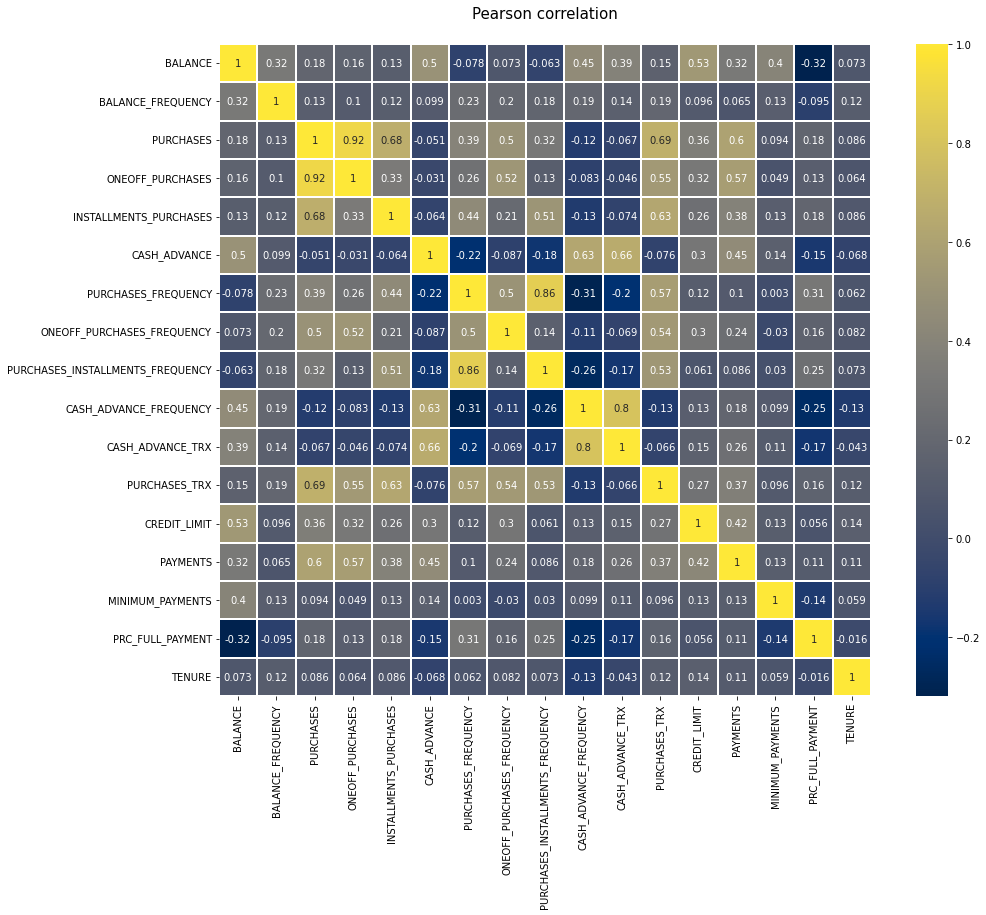

In [11]:
colormap = 'cividis'
plt.figure(figsize=(16,12))
plt.title('Pearson correlation', y=1.03, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

Based on the correlation matrix we can see some features with a fairly good correlation:
- ONEOFF_PURCHASES x PURCHASES = 0.92
- CASH_ADVANCE_TRX x CASH_ADVANCE_FREQUENCY = 0.8
- INSTALLMENTS_PURCHASES x PURCHASES = 0.68

Many other variables correlate between 0.5 and 0.7, which not very hight, but demonstrate a reasonable level of correlation.

### Data Processing

#### Filling missing data

In [41]:
num_col = df.select_dtypes(exclude=['object']).columns
num_col

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [42]:
imputer = KNNImputer()
imputed_data = imputer.fit_transform(df[num_col])
imputed_df = pd.DataFrame(imputed_data, columns=df[num_col].columns)

# Confirm if still there is missing values 
imputed_df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

#### Handling the skewness

For a clustering models, handling skewness in the data may not be a strict requirement, but addressing it can have benefits in terms of interpretability, since skewed data may affect the interpretability and visualization of clustering results. Transforming the data to reduce skewness can lead to better visual representations of clusters, allowing for easier interpretation and understanding of the clustering outcomes.

In [43]:
cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE']

In [44]:
# Create imputed_df_sk as copy of imputed_df to keep separated datasets
imputed_df_sk = imputed_df

for col in cols:
    imputed_df_sk[col] = np.log(1 + imputed_df[col])

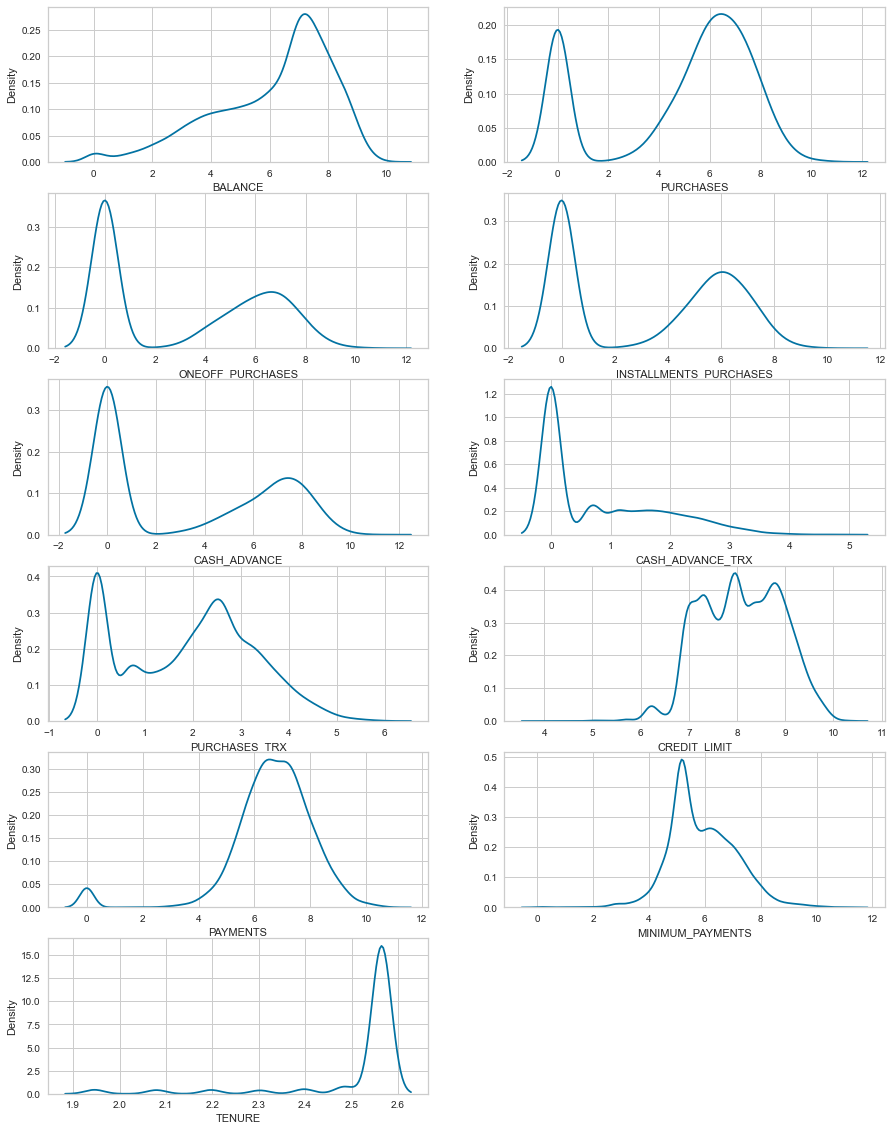

In [45]:
plt.figure(figsize=(15,20))
for i, col in enumerate(cols):
    ax = plt.subplot(6, 2, i+1)
    sns.kdeplot(imputed_df_sk[col], ax=ax)
plt.show()

### Clustering

#### K Means

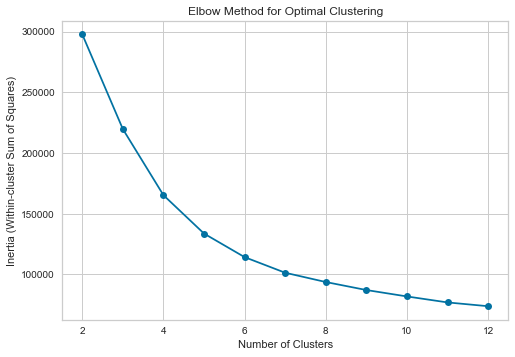

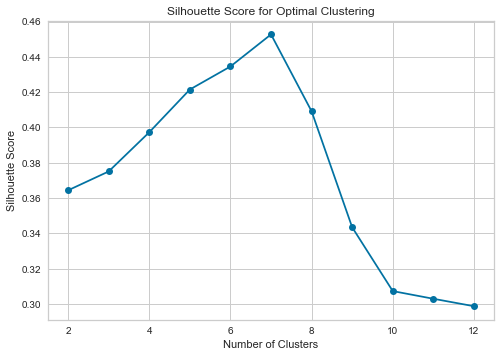

In [46]:
# Create a range of cluster numbers to test
cluster_range = range(2, 13)

# Initialize an empty list to store inertia values
inertia_values = []

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate through different numbers of clusters and calculate inertia
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(imputed_df_sk)
    inertia_values.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(imputed_df_sk, labels))

# Plot the inertia values against the number of clusters
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Clustering')
plt.show()

# Plot the silhouette scores against the number of clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clustering')
plt.show()

In [29]:
inertia_values

[478501.31881673227,
 297625.1653866733,
 219642.76189701492,
 165240.98226086103,
 133620.0366657848,
 114218.29465051187,
 101364.66162149764,
 93723.3586650492,
 87137.05135129481]

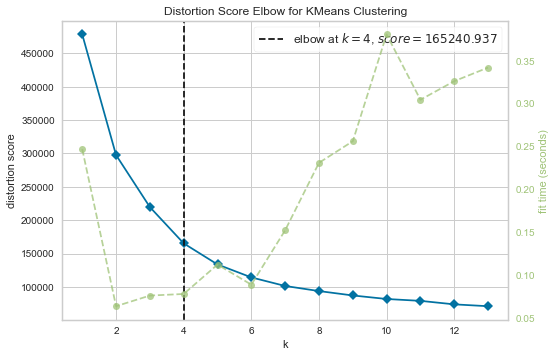

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,14))

visualizer.fit(imputed_df_sk)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

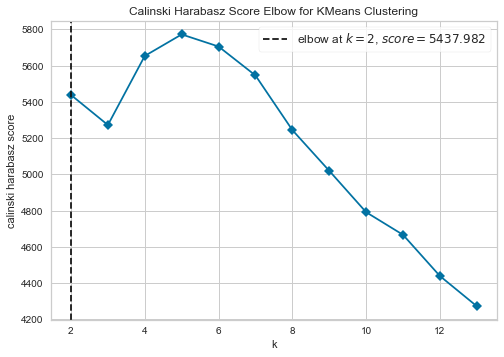

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [63]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,14), metric='calinski_harabasz', timings=False, locate_elbow=True
)

visualizer.fit(imputed_df_sk)        # Fit the data to the visualizer
visualizer.show()    